In [1]:
import numpy as np
import pandas as pd
import networkx as nx 
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import pickle
import json
from pathlib import Path
from tqdm import tqdm
from joblib import Parallel, delayed, dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
import _utilities

In [2]:
with open( './cells_of_interest.json', 'r') as f:
   cells_of_interest = json.load(f)

In [3]:
with open('./cells_info.pickle', 'rb') as f:
    cells_info = pickle.load(f)
cells_info['ABal']

{'mother_cell': 'ABa',
 'daughter_cells': ['ABala', 'ABalp'],
 'trajectory_raw': {'WT-EMB01':     frame      x      y   z
  0      14  17.16  23.98  19
  1      15  16.72  26.18  18
  2      16  16.94  27.50  16
  3      17  16.50  28.82  16
  4      18  14.74  28.82  18
  5      19  14.52  28.38  18
  6      20  14.74  27.72  19
  7      21  14.30  28.60  19
  8      22  13.86  28.38  18
  9      23  13.42  28.38  17
  10     24  13.20  28.82  16
  11     25  13.86  28.16  15
  12     26  14.52  26.62  16,
  'WT-EMB02':     frame      x      y   z
  0      25  16.94  23.54  13
  1      26  17.16  25.96  15
  2      27  17.38  26.62  16
  3      28  16.28  26.62  15
  4      29  14.52  26.40  14
  5      30  13.64  25.96  13
  6      31  14.30  25.30  13
  7      32  13.86  27.94  14
  8      33  14.08  26.84  15
  9      34  13.86  26.40  16
  10     35  14.08  25.96  15
  11     36  15.18  24.64  17
  12     37  16.28  23.98  16,
  'WT-EMB03':     frame      x      y   z
  0      12 

In [4]:
with open('./embryo_cells_info.pickle', 'rb') as f:
    embryo_cells_info = pickle.load(f)
embryo_cells_info['WT-EMB12']['ABal']

{'trajectory_processed':     frame          x         y         z
 0       1 -17.149992  0.614791  1.585662
 1       2 -16.269992  2.154791  1.585662
 2       3 -16.709992  4.354791  1.585662
 3       4 -18.249992  4.574791  3.585662
 4       5 -19.789992  3.474791  4.585662
 5       6 -20.889992  2.374791  3.585662
 6       7 -21.329992  4.354791  2.585662
 7       8 -21.109992  3.254791  2.585662
 8       9 -21.109992  3.034791  2.585662
 9      10 -20.889992  3.474791  0.585662
 10     11 -20.229992  2.814791 -1.414338,
 'trajectory_processed_txyz':      time          x         y         z
 0    1.25 -17.149992  0.614791  1.585662
 1    2.50 -16.269992  2.154791  1.585662
 2    3.75 -16.709992  4.354791  1.585662
 3    5.00 -18.249992  4.574791  3.585662
 4    6.25 -19.789992  3.474791  4.585662
 5    7.50 -20.889992  2.374791  3.585662
 6    8.75 -21.329992  4.354791  2.585662
 7   10.00 -21.109992  3.254791  2.585662
 8   11.25 -21.109992  3.034791  2.585662
 9   12.50 -20.889992 

In [5]:
embryos_for_test = ['WT-EMB05','WT-EMB12','WT-EMB19','WT-EMB26']
embryos_for_cross_validation = [embryo_name for embryo_name in embryo_cells_info if embryo_name not in embryos_for_test]

In [6]:
print(embryos_for_cross_validation)

['WT-EMB01', 'WT-EMB02', 'WT-EMB03', 'WT-EMB04', 'WT-EMB06', 'WT-EMB07', 'WT-EMB08', 'WT-EMB09', 'WT-EMB10', 'WT-EMB11', 'WT-EMB13', 'WT-EMB14', 'WT-EMB15', 'WT-EMB16', 'WT-EMB17', 'WT-EMB18', 'WT-EMB20', 'WT-EMB21', 'WT-EMB22', 'WT-EMB23', 'WT-EMB24', 'WT-EMB25', 'WT-EMB27', 'WT-EMB28']


In [7]:
len(embryos_for_cross_validation)

24

# 1. Cross Validation with all features 

In [8]:
# changing n_estimators in the forest
rf_cv_score = []
for i in tqdm(range(6)): # 6-fold cross-validation
    # train and val dataset
    embryos_val = embryos_for_cross_validation[4*i:4*i+4]
    embryos_train = [embryo_name for embryo_name in embryos_for_cross_validation if embryo_name not in embryos_val]
    X_train, _, y_train = _utilities.prepare_data_for_model(embryo_cells_info, embryos_train, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = True, flatten = True)
    X_val, _, y_val = _utilities.prepare_data_for_model(embryo_cells_info, embryos_val, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = True, flatten = True)
    X_train, y_train = shuffle(X_train, y_train, random_state=1)
    # X_val, y_val = shuffle(X_val, y_val, random_state=1)
    scores = []
    for n_trees in range(10, 200):
        forest = RandomForestClassifier(n_estimators=n_trees, random_state=1, n_jobs=10)
        forest.fit(X_train, y_train)
        scores.append(forest.score(X_val, y_val))
    rf_cv_score.append(scores.copy())

100%|██████████| 6/6 [1:29:38<00:00, 896.44s/it]


In [9]:
print(rf_cv_score)

[[0.9146706586826348, 0.9169161676646707, 0.9139221556886228, 0.9191616766467066, 0.9184131736526946, 0.9206586826347305, 0.9139221556886228, 0.9229041916167665, 0.9244011976047904, 0.9273952095808383, 0.9281437125748503, 0.9266467065868264, 0.9273952095808383, 0.9288922155688623, 0.9333832335329342, 0.9348802395209581, 0.9326347305389222, 0.9326347305389222, 0.9318862275449101, 0.9326347305389222, 0.9333832335329342, 0.937874251497006, 0.9356287425149701, 0.9393712574850299, 0.938622754491018, 0.9401197604790419, 0.9408682634730539, 0.9416167664670658, 0.9423652694610778, 0.9423652694610778, 0.9401197604790419, 0.9423652694610778, 0.9393712574850299, 0.9393712574850299, 0.9401197604790419, 0.9416167664670658, 0.9416167664670658, 0.9416167664670658, 0.9408682634730539, 0.9408682634730539, 0.9401197604790419, 0.9431137724550899, 0.9438622754491018, 0.9431137724550899, 0.9438622754491018, 0.9453592814371258, 0.9453592814371258, 0.9446107784431138, 0.9461077844311377, 0.9468562874251497, 

In [10]:
with open( './rf_cv_score_all_features.json', 'w') as f:
   json.dump(rf_cv_score, f)

In [8]:
with open( './rf_cv_score_all_features.json', 'r') as f:
   rf_cv_score = json.load(f)

In [9]:
np.array(rf_cv_score).shape

(6, 391)

In [14]:
-np.sort(-np.mean(rf_cv_score, axis=0))

array([0.94336327, 0.94311377, 0.94311377, 0.94311377, 0.94298902,
       0.94298902, 0.94298902, 0.94298902, 0.94298902, 0.94298902,
       0.94286427, 0.94286427, 0.94286427, 0.94286427, 0.94286427,
       0.94286427, 0.94286427, 0.94286427, 0.94286427, 0.94286427,
       0.94286427, 0.94273952, 0.94273952, 0.94273952, 0.94273952,
       0.94273952, 0.94261477, 0.94261477, 0.94261477, 0.94261477,
       0.94261477, 0.94261477, 0.94261477, 0.94261477, 0.94261477,
       0.94249002, 0.94249002, 0.94249002, 0.94249002, 0.94249002,
       0.94249002, 0.94249002, 0.94249002, 0.94236527, 0.94236527,
       0.94236527, 0.94236527, 0.94224052, 0.94224052, 0.94224052,
       0.94224052, 0.94224052, 0.94224052, 0.94211577, 0.94211577,
       0.94211577, 0.94211577, 0.94211577, 0.94199102, 0.94199102,
       0.94199102, 0.94199102, 0.94199102, 0.94199102, 0.94199102,
       0.94199102, 0.94199102, 0.94199102, 0.94199102, 0.94199102,
       0.94199102, 0.94199102, 0.94199102, 0.94199102, 0.94186

In [11]:
np.argsort(-np.mean(rf_cv_score, axis=0))+10

array([374, 373, 392, 375, 376, 358, 386, 377, 396, 393, 399, 359, 395,
       385, 397, 382, 381, 357, 353, 390, 378, 394, 356, 384, 387, 379,
       352, 388, 398, 355, 350, 380, 372, 383, 389, 360, 361, 351, 354,
       400, 370, 371, 391, 364, 366, 349, 368, 363, 367, 369, 348, 347,
       345, 315, 340, 339, 346, 284, 289, 307, 338, 294, 316, 337, 311,
       343, 204, 344, 310, 305, 285, 306, 328, 365, 309, 282, 287, 326,
       362, 314, 308, 198, 332, 327, 312, 313, 293, 290, 330, 286, 283,
       210, 325, 329, 331, 199, 336, 342, 318, 297, 319, 317, 321, 320,
       341, 206, 211, 323, 322, 235, 288, 296, 201, 212, 276, 275, 333,
       213, 245, 241, 254, 334, 278, 230, 200, 304, 335, 197, 302, 301,
       295, 277, 202, 255, 195, 214, 215, 247, 299, 246, 248, 234, 280,
       236, 225, 237, 298, 292, 260, 209, 303, 253, 257, 203, 232, 291,
       251, 207, 324, 249, 281, 190, 205, 193, 196, 240, 300, 250, 242,
       244, 238, 252, 279, 256, 233, 231, 226, 191, 192, 224, 22

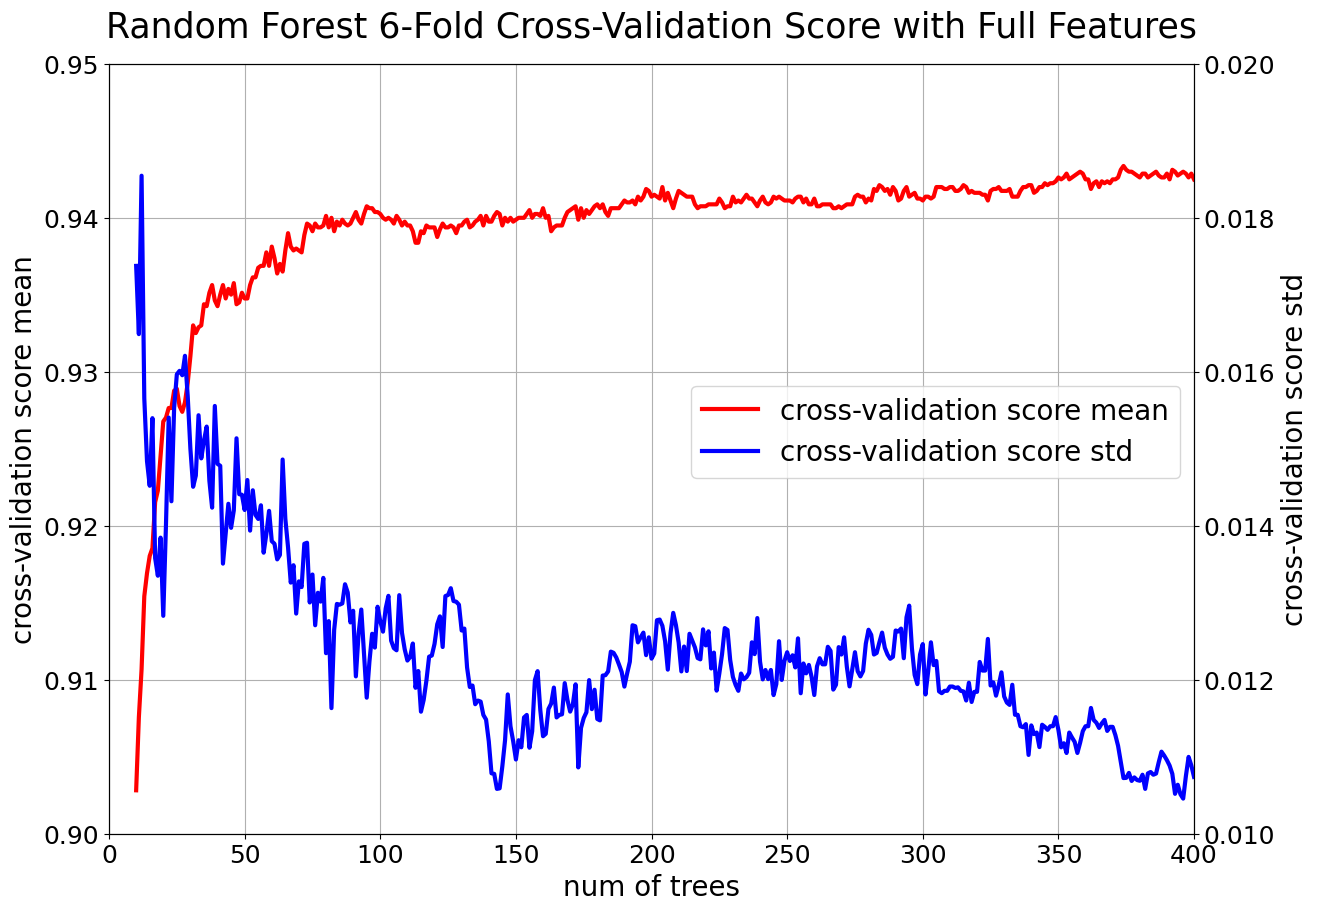

In [44]:
# plot num_trees vs cross_validation score mean and std
fig, ax1 = plt.subplots(figsize = (14,10))
ax1.plot(range(10,201),np.mean(rf_cv_score, axis=0), label = 'cross-validation score mean', color = 'r', linewidth = 3)
ax2 = ax1.twinx()
ax2.plot(range(10,201),np.std(rf_cv_score, axis=0), label = 'cross-validation score std', color = 'b', linewidth = 3)
ax1.grid()
ax1.set_xlim(0,200)
ax1.set_ylim(0.90, 0.95)
ax2.set_ylim(0.010, 0.020)
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
ax1.set_xlabel('num of trees', fontsize = 20)
ax1.set_ylabel('cross-validation score mean', fontsize = 20)
ax2.set_ylabel('cross-validation score std', fontsize = 20)
fig.legend(loc="upper right", bbox_to_anchor=(1,0.6), bbox_transform=ax1.transAxes, fontsize = 20)
ax1.set_title('Random Forest 6-Fold Cross-Validation Score with Full Features', fontsize = 25, y = 1.025)
fig.savefig('./random_forest_full_features_6_fold_cv_score.png')

## Random Forest score on 4 test samples

In [9]:
n_trees = 198
rf_test_score = []

# use all embryos_for_cross_validation data to retrain the model and test on the test embryo samples
X_train, _, y_train = _utilities.prepare_data_for_model(embryo_cells_info, embryos_for_cross_validation, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = True, flatten = True)
X_test, _, y_test = _utilities.prepare_data_for_model(embryo_cells_info, embryos_for_test, use_frame = True, lifespan_frame_longest = 50, preserve_time_dimension = True, flatten = True)
X_train, y_train = shuffle(X_train, y_train, random_state=1)
forest = RandomForestClassifier(n_estimators=n_trees, random_state=1, n_jobs=10)
forest.fit(X_train, y_train)
test_accuracy = forest.score(X_test, y_test)
print(f'Random Forest with full features, n_trees = {n_trees} accuracy on test embryos:', test_accuracy)

Random Forest with full features, n_trees = 198 accuracy on test embryos: 0.9296407185628742
